In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

#### Class for the Hopfield network algorithm

In [ ]:
class HopfieldNetwork:
    def __init__(self, num_neurons: int):
        self.num_neurons = num_neurons
        self.weights = np.zeros((num_neurons, num_neurons))

    def train(self, patterns: list[np.ndarray]):
        # Wire neurons based on Hebian rule
        for pattern in patterns:
            self.weights += np.outer(pattern, pattern)
        np.fill_diagonal(self.weights, 0)
        # Normalize weights
        self.weights /= self.num_neurons
        self.weights /= len(patterns)

    def _recover(self, activations_func, noisy_pattern: np.ndarray, max_iter):
        current_state = noisy_pattern.copy()
        for _ in range(max_iter):
            previous_state = current_state
            # Apply activation and check if state has changed
            current_state = activations_func(self, current_state)
            if np.array_equal(current_state, previous_state):
                return current_state
        return current_state

    def _activations_sync(self, current_state: np.ndarray):
        # Calculate the activation for all neurons at once
        activations = np.dot(self.weights, current_state)
        return np.where(activations >= 0, 1, -1)
    
    def _activations_async(self, current_state: np.ndarray):
        # Calculate activations in random order
        for i in np.random.permutation(self.num_neurons):
            activation = np.dot(self.weights[i, :], current_state)
            current_state[i] = 1 if activation >= 0 else -1
        return current_state
        
    def recover_sync(self, noisy_pattern: np.ndarray, max_iter=100):
        activations_func = HopfieldNetwork._activations_sync
        return self._recover(activations_func, noisy_pattern, max_iter)

    def recover_async(self, noisy_pattern: np.ndarray, max_iter=100):
        activations_func = HopfieldNetwork._activations_async
        return self._recover(activations_func, noisy_pattern, max_iter)

#### Define 2D patterns

In [3]:
pattern_T = np.array([
    [+1, +1, +1, +1, +1],
    [-1, -1, +1, -1, -1],
    [-1, -1, +1, -1, -1],
    [-1, -1, +1, -1, -1],
    [-1, -1, +1, -1, -1],
    [-1, -1, +1, -1, -1],
    [-1, -1, +1, -1, -1]
])

In [4]:
pattern_L = np.array([
    [+1, -1, -1, -1, -1],
    [+1, -1, -1, -1, -1],
    [+1, -1, -1, -1, -1],
    [+1, -1, -1, -1, -1],
    [+1, -1, -1, -1, -1],
    [+1, -1, -1, -1, -1],
    [+1, +1, +1, +1, +1]
])

In [5]:
pattern_C = np.array([
    [-1, +1, +1, +1, -1],
    [+1, -1, -1, -1, +1],
    [+1, -1, -1, -1, -1],
    [+1, -1, -1, -1, -1],
    [+1, -1, -1, -1, -1],
    [+1, -1, -1, -1, +1],
    [-1, +1, +1, +1, -1]
])

In [6]:
pattern_Plus = np.array([
    [-1, -1, -1, -1, -1],
    [-1, -1, +1, -1, -1],
    [-1, -1, +1, -1, -1],
    [+1, +1, +1, +1, +1],
    [-1, -1, +1, -1, -1],
    [-1, -1, +1, -1, -1],
    [-1, -1, -1, -1, -1]
])

#### Create and train the Hopfield network

In [7]:
patterns = [pattern_T, pattern_L, pattern_C, pattern_Plus]
patterns_flatten = [pattern.flatten() for pattern in patterns]
hopfield_net = HopfieldNetwork(pattern_T.shape[0] * pattern_T.shape[1])
hopfield_net.train(patterns_flatten)

#### Function to artificially create noise in the pattern

In [8]:
def noise_pattern(pattern: np.ndarray, noise_level: float):
    noisy_pattern = pattern.copy()
    # Randomly flip specified number of pixels
    num_flips = int(noise_level * len(pattern))
    flip_indices = np.random.choice(len(pattern), size=num_flips, replace=False)
    noisy_pattern[flip_indices] *= -1
    return noisy_pattern

#### Function to display pattern as grid

In [9]:
def display_pattern(pattern_vec: np.ndarray, title: str, shape: tuple):
    plt.imshow(pattern_vec.reshape(shape), cmap='binary', vmin=-1, vmax=1, interpolation='nearest')
    plt.title(title)
    plt.xticks([])
    plt.yticks([])

#### Test recovering the defined patterns

In [10]:
def test_pattern_recovery(hopfield_net: HopfieldNetwork, pattern: np.ndarray, name: str, noise=0.3):
    pattern_flatten = pattern.flatten()
    noisy_pattern = noise_pattern(pattern_flatten, noise)
    recovered_sync = hopfield_net.recover_sync(noisy_pattern, max_iter=50)
    recovered_async = hopfield_net.recover_async(noisy_pattern, max_iter=50)
    shape = (len(pattern), len(pattern[0]))
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 4, 1)
    display_pattern(pattern_flatten, f"Original '{name}'", shape)
    plt.subplot(1, 4, 2)
    display_pattern(noisy_pattern, f"Noisy '{name}' ({int(noise*100)}% noise)", shape)
    plt.subplot(1, 4, 3)
    display_pattern(recovered_sync, f"Recovered (Sync)", shape)
    plt.subplot(1, 4, 4)
    display_pattern(recovered_async, f"Recovered (Async)", shape)
    plt.tight_layout()
    plt.show()

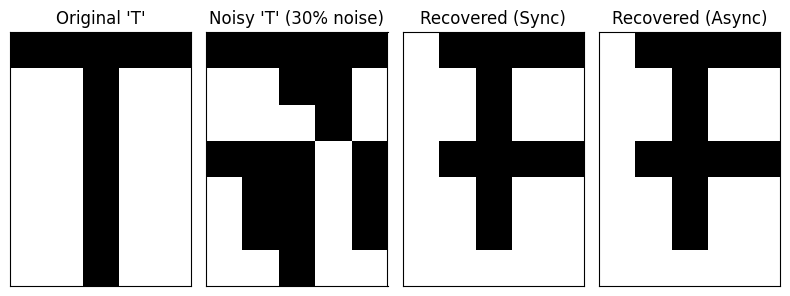

In [11]:
test_pattern_recovery(hopfield_net, pattern_T, "T")

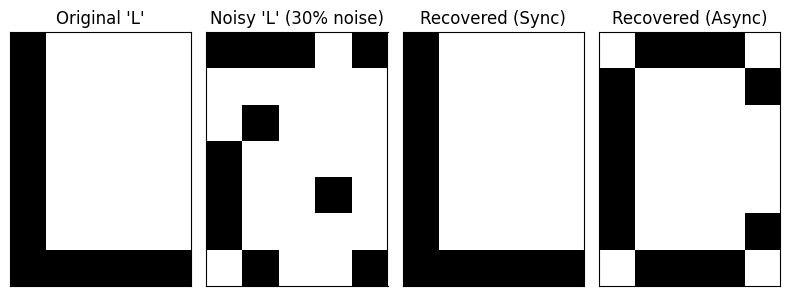

In [12]:
test_pattern_recovery(hopfield_net, pattern_L, "L")

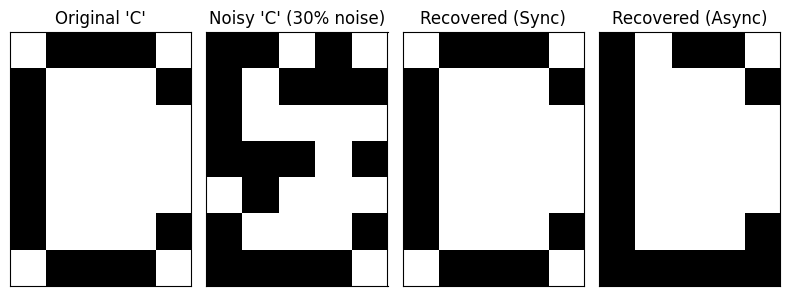

In [13]:
test_pattern_recovery(hopfield_net, pattern_C, "C")

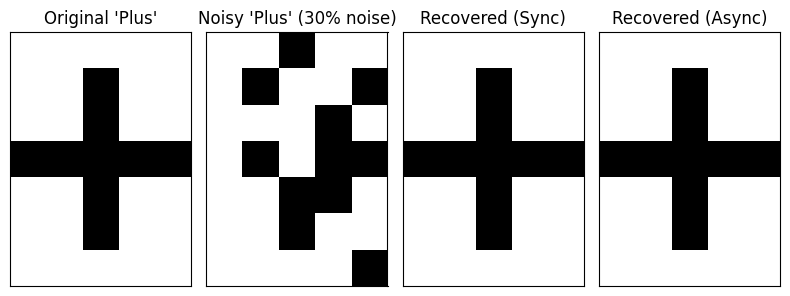

In [14]:
test_pattern_recovery(hopfield_net, pattern_Plus, "Plus")